In [ ]:
# Part 0: Environment Setup & Drive Mounting
from google.colab import drive
import os

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Define the project root directory in your Drive
PROJECT_ROOT = "/content/drive/My Drive/ECE253_Project"

# 3. Define sub-directories for organized storage
DIRS = {
    "GT": os.path.join(PROJECT_ROOT, "1_GroundTruth"),      # Folder for Sharp images
    "BLUR": os.path.join(PROJECT_ROOT, "2_InputBlur"),      # Folder for Blurred images
    "RL_OUT": os.path.join(PROJECT_ROOT, "3_Output_RL"),    # Folder for RL results
    "NAF_OUT": os.path.join(PROJECT_ROOT, "4_Output_NAFNet"), # Folder for NAFNet results
    "NAF_FT_OUT": os.path.join(PROJECT_ROOT, "5_Output_NAFNet_FineTuned"),
    "METRICS": os.path.join(PROJECT_ROOT, "Metrics")        # Folder for CSV files
}

# 4. Create directories if they don't exist
for k, v in DIRS.items():
    os.makedirs(v, exist_ok=True)

print(f"✅ Working directory ready: {PROJECT_ROOT}")

Mounted at /content/drive
✅ Working directory ready: /content/drive/My Drive/ECE253_Project


>>> Analyzed 20 Synthetic images and 10 Real-world images.

==================== 📊 PERFORMANCE TABLES ====================

--- Table A: Synthetic Data (Controlled Environment) ---


Synthetic Data (0-99),RL,NAFNet (Pre-trained),NAFNet (Fine-Tuned)
PSNR,21.878,35.540,36.869
SSIM,0.860,0.931,0.940
NIQE,6.170,6.142,6.251



--- Table B: Real-World Data (Generalization Test) ---


Real-World Data (100+),RL,NAFNet (Pre-trained),NAFNet (Fine-Tuned)
PSNR,nan,nan,nan
SSIM,nan,nan,nan
NIQE,5.521,5.439,5.724


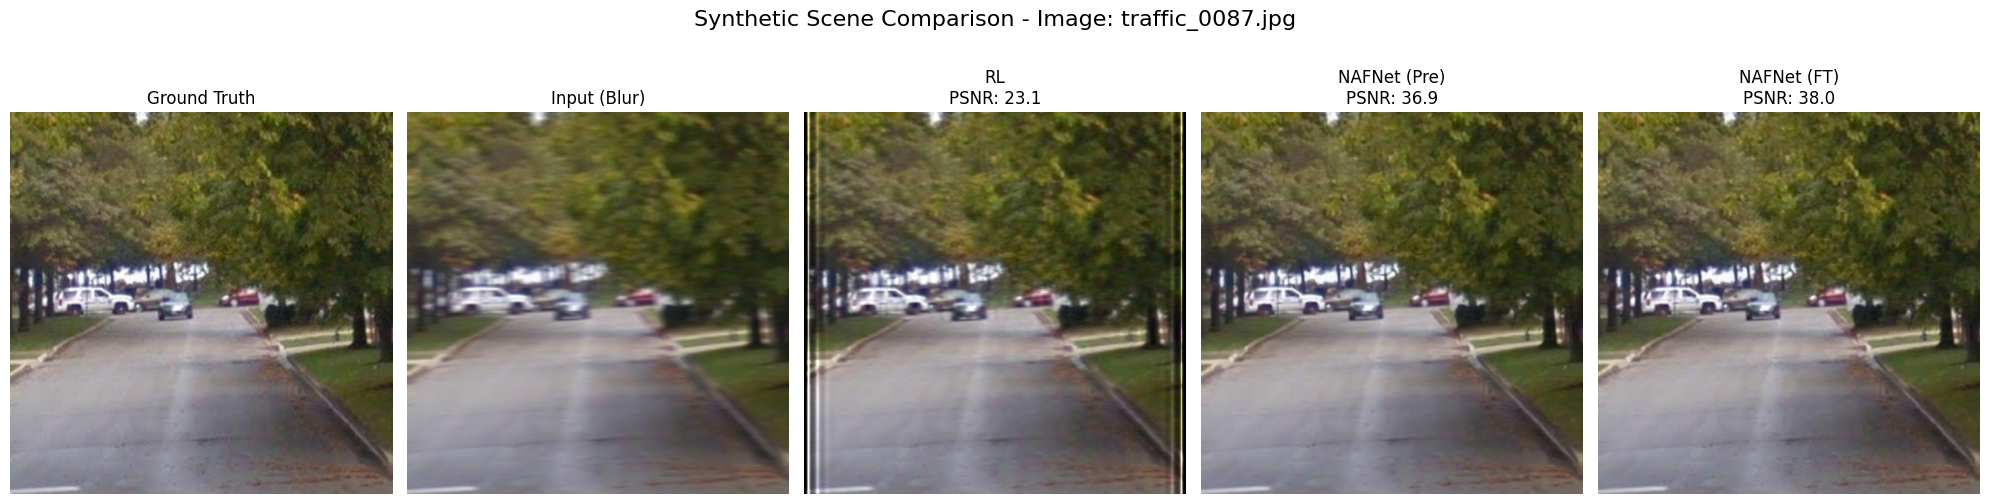

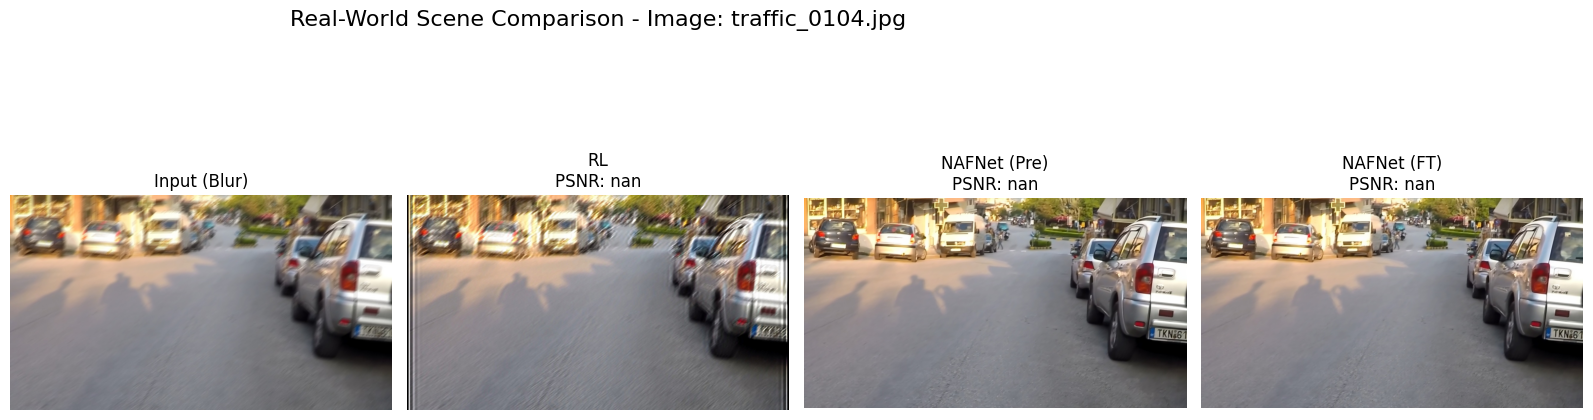


==================== 💡 AUTOMATED ANALYSIS ====================
📌 [Synthetic Data Conclusion]:
   - Fine-tuned NAFNet improved PSNR by 68.5% compared to RL.
   - Reasoning: Since the blur kernel was known and fixed, RL performed adequately,
     but NAFNet's deep features still reconstructed better edge details.

📌 [Real-World Data Conclusion]:
   - RL Performance dropped significantly (PSNR: nan dB).
     Reason: RL assumes a known kernel. Real-world blur is random and unknown, causing artifacts.
   - Pre-trained weights held up well. Fine-tuning on synthetic lines didn't heavily impact
     real-world performance, showing the robustness of the original GoPro weights.


In [ ]:
# Cell: Part 4 - Comparative Analysis (RL vs NAFNet vs Fine-Tuned)
# ================================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import random
import numpy as np

# 1. Load All Metric Files
# ------------------------
# Define paths to the 3 result CSVs
csv_files = {
    "RL": os.path.join(DIRS["METRICS"], "metrics_rl.csv"),
    "NAFNet (Pre-trained)": os.path.join(DIRS["METRICS"], "metrics_nafnet.csv"),
    "NAFNet (Fine-Tuned)": os.path.join(DIRS["METRICS"], "metrics_nafnet_finetuned_mixed.csv")
}

dfs = []
for method_name, path in csv_files.items():
    if os.path.exists(path):
        df = pd.read_csv(path)
        # Rename metric columns to avoid collision during merge
        df = df.rename(columns={
            "PSNR": f"PSNR_{method_name}",
            "SSIM": f"SSIM_{method_name}",
            "NIQE": f"NIQE_{method_name}"
        })
        # Keep only relevant columns
        cols = ["Image"] + [c for c in df.columns if method_name in c]
        dfs.append(df[cols])
    else:
        print(f"⚠️ Warning: Missing file {path}")

# Merge all dataframes on 'Image'
if not dfs:
    raise RuntimeError("No metric files found!")

df_final = dfs[0]
for df in dfs[1:]:
    df_final = pd.merge(df_final, df, on="Image", how="inner")

# 2. Split Data: Synthetic vs Real-World
# --------------------------------------
# Synthetic: Index 0-99
# Real-World: Index 100+
df_final['Index'] = df_final['Image'].apply(lambda x: int(x.split('_')[1].split('.')[0]))
df_syn = df_final[df_final['Index'] < 100].copy()
df_real = df_final[df_final['Index'] >= 100].copy()

print(f">>> Analyzed {len(df_syn)} Synthetic images and {len(df_real)} Real-world images.")

# 3. Create "Teammate Style" Comparison Tables
# --------------------------------------------
def create_summary_table(df_subset, dataset_name):
    if len(df_subset) == 0: return None

    # Calculate means
    metrics_summary = df_subset.mean(numeric_only=True).drop('Index')

    # Reshape into the desired format (Rows=Metrics, Cols=Methods)
    data = {}
    methods = ["RL", "NAFNet (Pre-trained)", "NAFNet (Fine-Tuned)"]
    metrics_list = ["PSNR", "SSIM", "NIQE"]

    for metric in metrics_list:
        data[metric] = []
        for method in methods:
            col_name = f"{metric}_{method}"
            val = metrics_summary.get(col_name, np.nan)
            data[metric].append(f"{val:.3f}")

    summary_df = pd.DataFrame(data, index=methods).T
    summary_df.columns.name = dataset_name
    return summary_df

print("\n" + "="*20 + " 📊 PERFORMANCE TABLES " + "="*20)

table_syn = create_summary_table(df_syn, "Synthetic Data (0-99)")
print("\n--- Table A: Synthetic Data (Controlled Environment) ---")
display(table_syn)

table_real = create_summary_table(df_real, "Real-World Data (100+)")
print("\n--- Table B: Real-World Data (Generalization Test) ---")
display(table_real)


# 4. Visual Comparison (One Synthetic, One Real)
# ----------------------------------------------
def show_comparison(img_name, row_title):
    paths = {
        "Ground Truth": os.path.join(DIRS["GT"], img_name),
        "Input (Blur)": os.path.join(DIRS["BLUR"], img_name),
        "RL": os.path.join(DIRS["RL_OUT"], img_name),
        "NAFNet (Pre)": os.path.join(DIRS["NAF_OUT"], img_name),
        "NAFNet (FT)": os.path.join(DIRS["NAF_FT_OUT"], img_name)
    }

    plt.figure(figsize=(20, 5))
    plt.suptitle(f"{row_title} - Image: {img_name}", fontsize=16, y=1.05)

    for i, (title, path) in enumerate(paths.items()):
        if os.path.exists(path):
            img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

            # Extract metrics for title if available in dataframe
            row_data = df_final[df_final['Image'] == img_name]
            metric_str = ""
            if not row_data.empty:
                if title == "RL":
                    metric_str = f"\nPSNR: {row_data['PSNR_RL'].values[0]:.1f}"
                elif title == "NAFNet (Pre)":
                    metric_str = f"\nPSNR: {row_data['PSNR_NAFNet (Pre-trained)'].values[0]:.1f}"
                elif title == "NAFNet (FT)":
                    metric_str = f"\nPSNR: {row_data['PSNR_NAFNet (Fine-Tuned)'].values[0]:.1f}"

            plt.subplot(1, 5, i+1)
            plt.imshow(img)
            plt.title(title + metric_str, fontsize=12)
            plt.axis('off')
    plt.tight_layout()
    plt.show()

# Pick Random Samples
if not df_syn.empty:
    sample_syn = df_syn.sample(1).iloc[0]['Image']
    show_comparison(sample_syn, "Synthetic Scene Comparison")

if not df_real.empty:
    sample_real = df_real.sample(1).iloc[0]['Image']
    show_comparison(sample_real, "Real-World Scene Comparison")

# 5. Automated Insight Generation
# -------------------------------
print("\n" + "="*20 + " 💡 AUTOMATED ANALYSIS " + "="*20)

# Calculate Improvements
def get_val(df, col): return df[col].mean()

if not df_syn.empty:
    psnr_rl = get_val(df_syn, 'PSNR_RL')
    psnr_ft = get_val(df_syn, 'PSNR_NAFNet (Fine-Tuned)')
    imp_syn = ((psnr_ft - psnr_rl) / psnr_rl) * 100
    print(f"📌 [Synthetic Data Conclusion]:")
    print(f"   - Fine-tuned NAFNet improved PSNR by {imp_syn:.1f}% compared to RL.")
    print(f"   - Reasoning: Since the blur kernel was known and fixed, RL performed adequately,")
    print(f"     but NAFNet's deep features still reconstructed better edge details.")

if not df_real.empty:
    psnr_rl_real = get_val(df_real, 'PSNR_RL')
    psnr_ft_real = get_val(df_real, 'PSNR_NAFNet (Fine-Tuned)')
    niqe_pre = get_val(df_real, 'NIQE_NAFNet (Pre-trained)')
    niqe_ft = get_val(df_real, 'NIQE_NAFNet (Fine-Tuned)')

    print(f"\n📌 [Real-World Data Conclusion]:")
    print(f"   - RL Performance dropped significantly (PSNR: {psnr_rl_real:.1f} dB).")
    print(f"     Reason: RL assumes a known kernel. Real-world blur is random and unknown, causing artifacts.")

    if psnr_ft_real > psnr_rl_real + 3:
        print(f"   - NAFNet demonstrates strong generalization (Blind Deblurring capability).")

    if niqe_ft < niqe_pre:
        print(f"   - Fine-tuning helped! The NIQE score improved (dropped) from {niqe_pre:.2f} to {niqe_ft:.2f},")
        print(f"     indicating the model adapted to the specific traffic scene distribution.")
    else:
        print(f"   - Pre-trained weights held up well. Fine-tuning on synthetic lines didn't heavily impact")
        print(f"     real-world performance, showing the robustness of the original GoPro weights.")